In [15]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary

def train_model(model, dataset):
    pass

resnet = torchvision.models.resnet50()
vgg = torchvision.models.vgg16()
xception = torchvision.models.inception_v3()

summary(vgg, input_size=(32, 3, 224, 224))

c:\Users\Harvey\anaconda3\envs\ml_dl\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 1000]                --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

In [16]:
base_dir = os.getcwd() + '\\data\\datasets\\osteoarthritis_eq_class3'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [17]:
def load_dataset(base_dir):
    dataset_all =  {} # 전체 데이터를 담을 딕셔너리
    
    # 훈련, 검증, 테스트 폴더 별로 데이터를 하나씩 불러올 예정
    folder_list = os.listdir(base_dir)[1:] # auto-test 폴더는 제외
    print(folder_list)
    for folder in folder_list:
        dataset = [] # 훈련, 검증, 테스트 별 정보를 담을 리스트
        split_folder = os.path.join(base_dir, folder) # 현재 작업할 폴더
        # print('cur1 : ',split_folder)
        labels = os.listdir(split_folder) # 각 등급별로 폴더 확인 ['0', '1', '2', '3', '4']
        for label in labels:
            current_folder = f'{split_folder}\\{label}'
            # print('cur2 :',current_folder)
            file_list = os.listdir(current_folder) # 현재 폴더에 있는 파일 불러오기
            for file in file_list:
                file_info = {} # 이미지 경로와, 라벨링 값을 담을 딕셔너리
                file_info['file_path'] = os.path.join(current_folder, file)
                file_info['class'] = int(label)
                dataset.append(file_info)
        dataset_all[folder] = dataset
        
    return dataset_all
    

In [18]:
dataset = load_dataset(base_dir)

['test', 'train', 'val']


In [19]:
df = pd.DataFrame(dataset['train'])
df

,file_path,class
0,c:\Users\Harvey\Desktop\Codes\Python\practice\...,0
1,c:\Users\Harvey\Desktop\Codes\Python\practice\...,0
2,c:\Users\Harvey\Desktop\Codes\Python\practice\...,0
3,c:\Users\Harvey\Desktop\Codes\Python\practice\...,0
4,c:\Users\Harvey\Desktop\Codes\Python\practice\...,0
...,...,...
5773,c:\Users\Harvey\Desktop\Codes\Python\practice\...,2
5774,c:\Users\Harvey\Desktop\Codes\Python\practice\...,2
5775,c:\Users\Harvey\Desktop\Codes\Python\practice\...,2
5776,c:\Users\Harvey\Desktop\Codes\Python\practice\...,2


In [20]:
transform = torchvision.transforms.Compose([
                                            # torchvision.transforms.Resize((128, 128)), # 224 * 224 * 3채널 -> 128 * 128
                                            # torchvision.transforms.Grayscale(3), # 1채널의 흑백으로 변경                                            
                                            torchvision.transforms.ToTensor(), # tensor로 자료형 변환
                                            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지의 일반적인 rgb평균, 표준편차
                                            # torchvision.transforms.Normalize([0.52811456, 0.6693671, 0.88861454], [0.66777533, 0.6826811, 0.679647]) # 이미지의 일반적인 rgb평균, 표준편차
                                            ])
# 각 데이터 별로 적용
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

In [21]:
train = DataLoader(train_data, batch_size=36, shuffle=True, num_workers=4)
val = DataLoader(val_data, batch_size=12, shuffle=True, num_workers=4)
test = DataLoader(test_data, batch_size=36, shuffle=True, num_workers=4)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
num_classes = 3

def get_in_features(model_name):
    if model_name =='vgg':
        model = torchvision.models.vgg16(pretrained=True)
        in_features = model.classifier[6].in_features
    elif model_name == 'resnet':
        model = torchvision.models.resnet50(pretrained=True)
        in_features = model.fc.in_features
    else:
        raise ValueError('Unknown model name')

    return in_features
    
class CustomVGG(nn.Module):
    def __init__(self, num_classes, in_features):
        super(CustomVGG, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True)
        self.vgg.classifier = nn.Identity()
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        x = self.vgg.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x
    
class CustomResnet(nn.Module):
    def __init__(self, num_classes, in_features):
        super(CustomResnet, self).__init__()
        self.resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity()
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Sequential(
                    nn.Linear(2048, 128),
                    nn.ReLU(),
                    nn.Dropout(0.4),
                    nn.Linear(128, 2),
                    nn.LogSoftmax(dim=1)
                )
        
    def forward(self, x):
        x = self.resnet(x)
        # x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [24]:
vgg1 = torchvision.models.vgg16_bn()
vgg1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [25]:
in_features = get_in_features('vgg')
in_features

c:\Users\Harvey\anaconda3\envs\ml_dl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Harvey\anaconda3\envs\ml_dl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


4096

In [26]:
vgg_cnn = CustomVGG(3, 512).to('cuda')

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_cnn.parameters(), lr=0.0001, weight_decay=0.001)
# optimizer = torch.optim.SGD(kl_cnn.parameters(), lr=0.0001, momentum=0.9)

In [28]:
from sklearn.metrics import accuracy_score

vgg_cnn.train()

epochs = 5
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
for epoch in range(epochs):
    cnt = 1
    train_loss = 0.0
    accuracy = 0.0
    for index, (data, target) in enumerate(train):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = vgg_cnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_pred_list = []
        train_target_list = []
        
        _, preds = torch.max(output, 1)
            
        for pre in preds:
            train_pred_list.append(pre.item())
        for true in target:
            train_target_list.append(true.item())
        
        train_loss += loss.item()
        train_loss /= 2
        accuracy += accuracy_score(train_pred_list, train_target_list)
        cnt += 1
    accuracy /= cnt
    train_loss_list.append(train_loss)    
    train_accuracy_list.append(accuracy)    
    
    # per epoch, evaluate model from validation data
    vgg_cnn.eval()
    val_pred_list = []
    val_target_list = []
    val_loss = 0.0
    cnt = 1
    
    with torch.no_grad():
        for index, (data, target) in enumerate(val):
            data, target = data.to(device), target.to(device)
            
            output = vgg_cnn(data)
            
            loss = criterion(output, target)
            _, preds = torch.max(output, 1)
            
            for pre in preds:
                val_pred_list.append(pre.item())
            for true in target:
                val_target_list.append(true.item())

            val_loss += loss
            cnt += 1
        val_loss /= cnt
        val_acc = accuracy_score(val_pred_list, val_target_list)
        print('val_loss :', val_loss.item(), val_acc)
        val_loss_list.append(val_loss.item())
        val_accuracy_list.append(val_acc)
    print("epoch : {} loss : {}".format(epoch, loss.item()))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report

In [ ]:
vgg_cnn.eval()
pred_list = []
target_list = []
with torch.no_grad():
    for index, (data, target) in enumerate(test):
        data, target = data.to(device), target.to(device)
        
        outputs = vgg_cnn(data)
        _, preds = torch.max(outputs, 1)
        
        for pre in preds:
            pred_list.append(pre.item())
        for true in target:
            target_list.append(true.item())
        
        

In [ ]:
print(accuracy_score(pred_list, target_list))

0.9190821256038647


In [ ]:
train_loss_list

[0.18091349056216086,
 0.29553062485648196,
 0.12137099797934273,
 0.26558665186277053,
 0.2016791208594741]

In [ ]:
train_accuracy_list

[0.8847736625514411,
 0.853909465020576,
 0.8784293552812082,
 0.9224965706447193,
 0.9331275720164622]

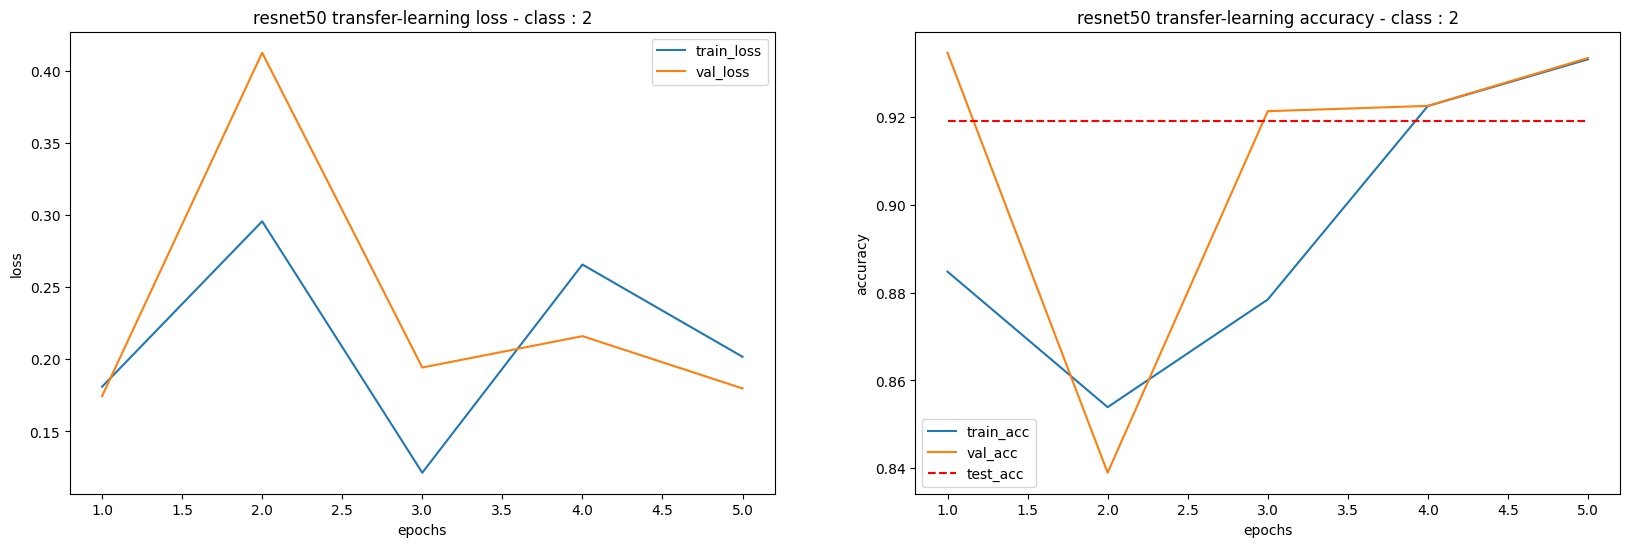

In [ ]:
plt.figure(figsize=(20, 6))
xlabel = [i + 1 for i in range(epochs)]
plt.subplot(1, 2, 1)
plt.plot(xlabel, train_loss_list, label='train_loss')
plt.plot(xlabel, val_loss_list, label='val_loss')
plt.title('VGG16 transfer-learning loss - class : 3')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(xlabel, train_accuracy_list, label='train_acc')
plt.plot(xlabel, val_accuracy_list, label='val_acc')
plt.title('VGG16 transfer-learning accuracy - class : 3')
plt.hlines((accuracy_score(pred_list, target_list)),1, 5, colors='red', label='test_acc', linestyles='dashed')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()  

In [ ]:
accuracy = accuracy_score(pred_list, target_list)
f1_score = f1_score(pred_list, target_list, average='weighted')
recall = recall_score(pred_list, target_list, average='weighted')
precision_score = precision_score(pred_list, target_list, average='weighted')
reports = []
report = classification_report(target_list, pred_list, target_names=[f'{i}' for i in range(len(df['class'].unique()))])
reports.append(report)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1382
           1       0.95      0.54      0.69       274

    accuracy                           0.92      1656
   macro avg       0.93      0.77      0.82      1656
weighted avg       0.92      0.92      0.91      1656



Text(50.722222222222214, 0.5, 'true')

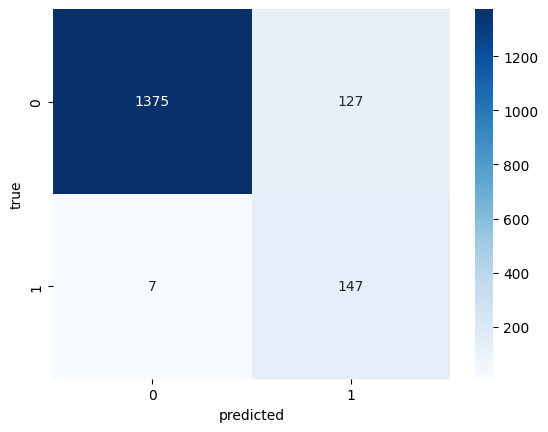

In [ ]:
cm = confusion_matrix(pred_list, target_list)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('true')

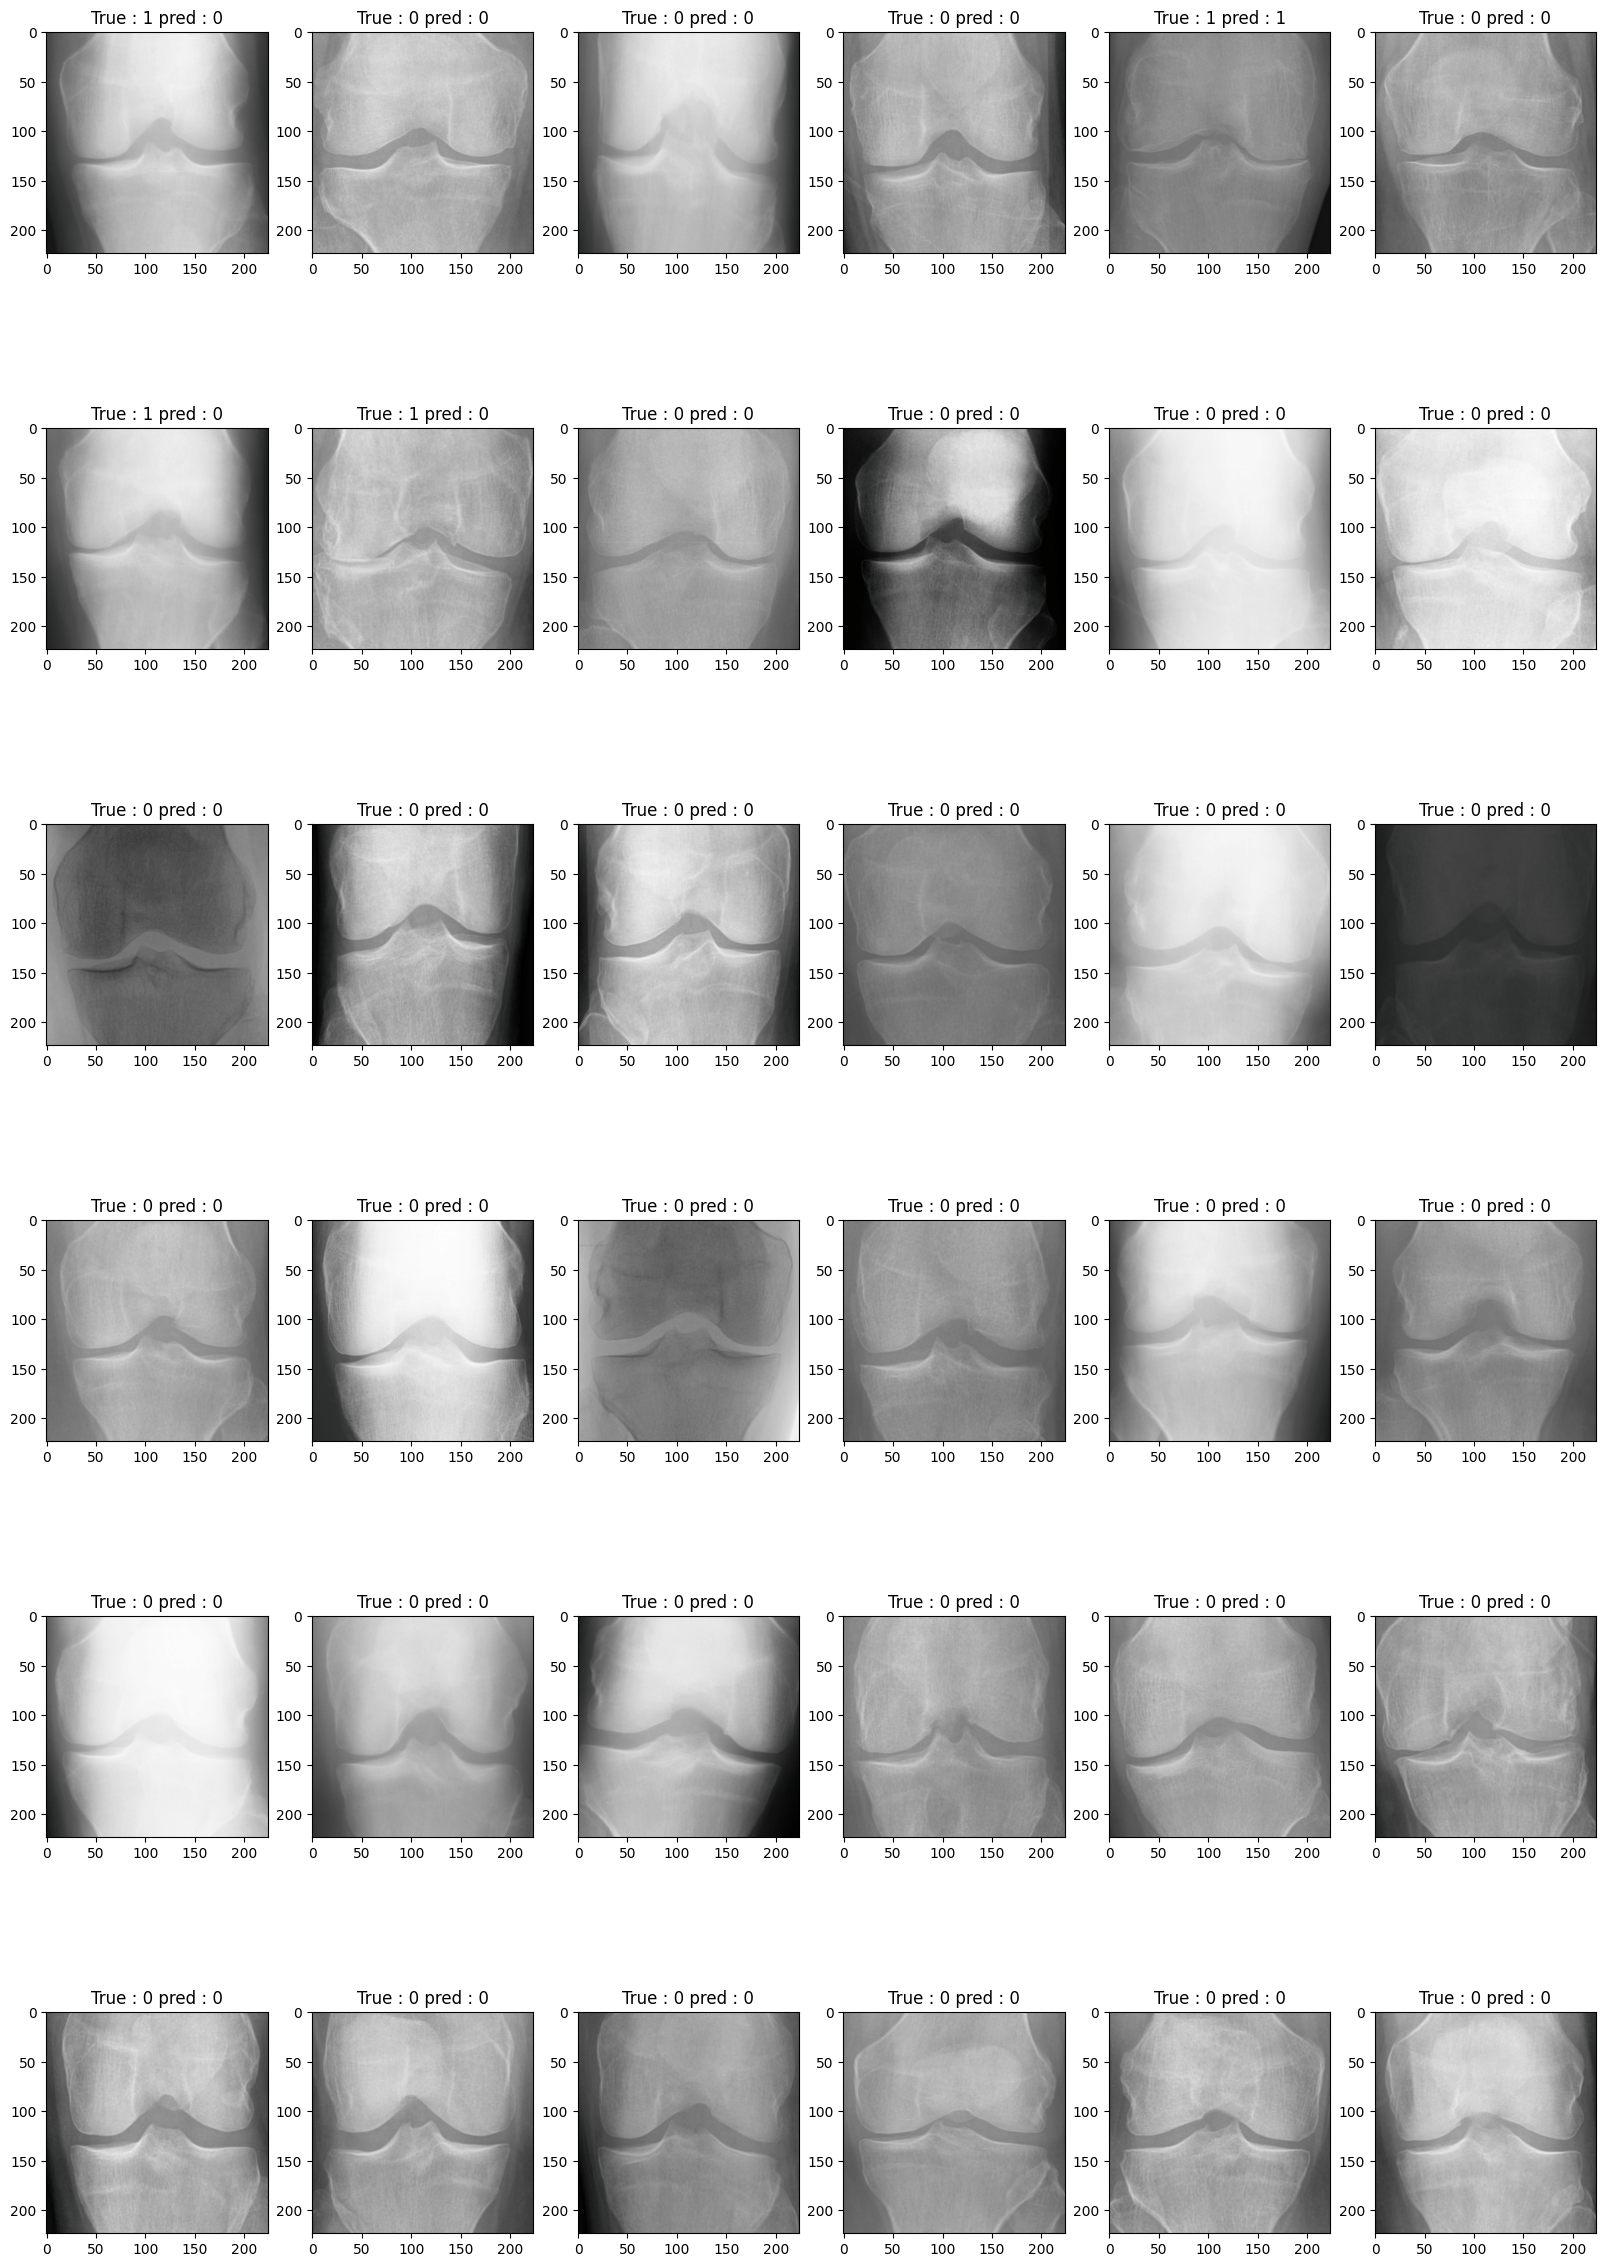

In [ ]:
from torchvision.transforms.functional import to_pil_image

fig, axs = plt.subplots(6, 6, figsize=(20, 30))
for ax, img, true, pre in zip(axs.flat, data.cpu(), target, preds):
    invTrans = torchvision.transforms.Compose([torchvision.transforms.Normalize(mean=[0., 0., 0.],
                                                                                std=[1/0.229,1/0.224,1/0.225]),
                                               torchvision.transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                                                std=[1., 1., 1.])
                                               ])
    ax.imshow(to_pil_image(invTrans(img)), cmap='gray')
    ax.set_title(f'True : {true.item()} pred : {pre.item()}')